In [8]:
import numpy as np
import cv2 
from scipy import ndimage
import matplotlib.pyplot as plt
from skimage.transform import rescale, resize,downscale_local_mean
from skimage.filters import roberts,sobel,scharr,prewitt
from skimage.feature import canny
from skimage import restoration
from skimage import io 
import scipy.stats as st #statistics package in scipy for normalization
from skimage.filters.rank import entropy
from skimage.morphology import disk

In [2]:
#img=io.imread('test.jpg')
img=io.imread('test.jpg',as_gray=True)
train=io.imread('train.png',as_gray=True)

In [4]:
img.dtype


dtype('uint8')

In [10]:
img

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

#### Flipping the image

In [18]:
left=np.fliplr(img)
updown=np.flipud(img)

In [31]:
rotated= ndimage.rotate(img,45 ,reshape=False)
rotated= ndimage.rotate(img,45 ,reshape=True)

#### Filters

In [33]:
uniform_filt=ndimage.uniform_filter(img,size=3)  #iniform filter is a learning filter

In [39]:
gaus=ndimage.gaussian_filter(img,sigma=7)#gausian filter to smooth the noise

gaussian filter will blur the edges instead of preserving
but mean filtering will preserve the edges

In [44]:
median=ndimage.median_filter(img,15)

In [54]:
#sobel=ndimage.sobel(img) #default  axis=-1
sobel=ndimage.sobel(img,axis=-1) 

#### Rescale

In [68]:
rescaled=rescale(img,1.0/4.0,anti_aliasing=True)
resize=resize(img,(100,100))
down=downscale_local_mean(img,(4,3))

#### EDGE Detection

In [78]:
edger=roberts(img)
edges=sobel(img)
edgesc=scharr(img)

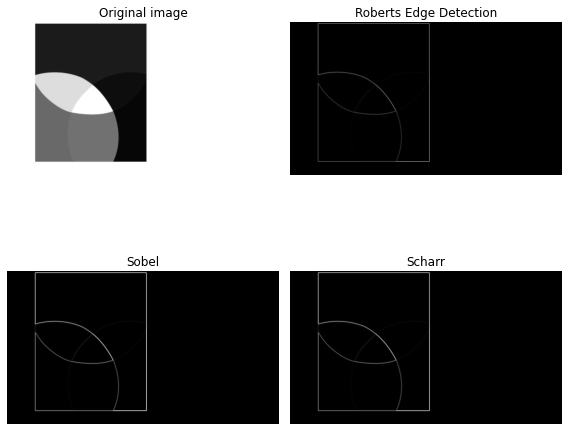

In [83]:
fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True,
                         figsize=(8, 8))
ax = axes.ravel()

ax[0].imshow(img, cmap=plt.cm.gray)
ax[0].set_title('Original image')

ax[1].imshow(edger, cmap=plt.cm.gray)
ax[1].set_title('Roberts Edge Detection')

ax[2].imshow(edges, cmap=plt.cm.gray)
ax[2].set_title('Sobel')

ax[3].imshow(edgesc, cmap=plt.cm.gray)
ax[3].set_title('Scharr')

for a in ax:
    a.axis('off')

plt.tight_layout()
plt.show()


In [93]:
edgecanny=canny(img,sigma=3)

In [9]:
cv2.imshow('First image',img)
cv2.waitKey()
cv2.destroyAllWindows()

#### Deconvolution

In [126]:
psf=np.ones((3,3)) /9  #point spread function 

In [123]:
imgd, _ =restoration.unsupervised_wiener(img,psf)

In [12]:
""" here we  create a matrix of gaussian kernel and use this as a point spread function"""

import scipy.stats as st #statistics package in scipy
import numpy as np
def gkern(kernlen=21, nsig=2):    #Returns a 2D Gaussian kernel. 

    lim = kernlen//2 + (kernlen % 2)/2
    x = np.linspace(-lim, lim, kernlen+1)
    kern1d = np.diff(st.norm.cdf(x))
    kern2d = np.outer(kern1d, kern1d)
    return kern2d/kern2d.sum()



In [13]:
psf = gkern(5,3)   #Kernel length and sigma
print(psf)


deconvolved, _ = restoration.unsupervised_wiener(img, psf)

[[0.003765   0.015019   0.02379159 0.015019   0.003765  ]
 [0.015019   0.05991246 0.0949073  0.05991246 0.015019  ]
 [0.02379159 0.0949073  0.15034262 0.0949073  0.02379159]
 [0.015019   0.05991246 0.0949073  0.05991246 0.015019  ]
 [0.003765   0.015019   0.02379159 0.015019   0.003765  ]]


#### Entropy

In [ ]:
entrooy is one of the texture filter used to qualtify the dissoreder compared to the clean area of the images
it used a parameter called disc , we need to improt disc

In [10]:
from skimage.filters.rank import entropy
from skimage.morphology import disk

In [19]:
img=io.imread('NLM.jpg',as_gray=True)

In [20]:
entr=entropy(img,disk(5))

C:\Users\kiran\anaconda_new\lib\site-packages\IPython\core\interactiveshell.py:3437: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


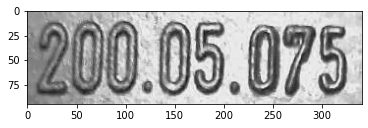

In [21]:
plt.imshow(img,cmap='gray')

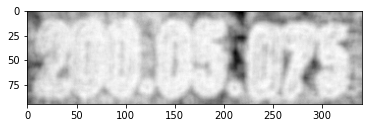

In [22]:
plt.imshow(entr,cmap='gray')

##### To Check the best filters

In [23]:
from skimage.filters import try_all_threshold

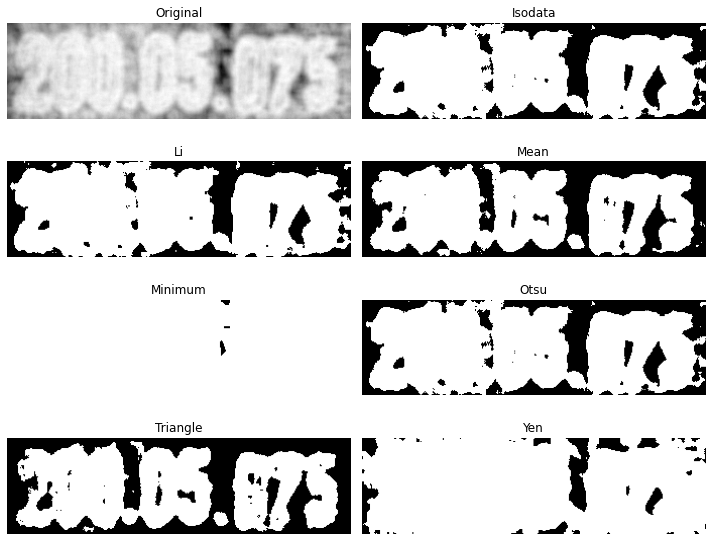

In [24]:
fig,ax =try_all_threshold(entr, figsize=(10,8),verbose =False)
plt.show()

#### Applying otsu

In [85]:
from skimage.filters import threshold_otsu

In [86]:
thresh =threshold_otsu(entr)
binary=entr<=thresh

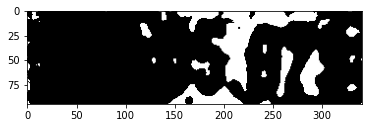

In [87]:
plt.imshow(binary,cmap='gray')

#### Denoising with  Non Local Means

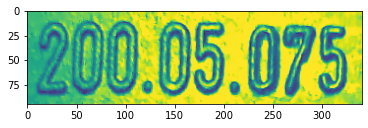

In [18]:
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage import img_as_ubyte, img_as_float
from matplotlib import pyplot as plt
from skimage import io
import numpy as np

img = img_as_float(io.imread('crjt145.png',as_gray=True))
#Need to convert to float as we will be doing math on the array

from scipy import ndimage as nd
gaussian_img = nd.gaussian_filter(img, sigma=3)
plt.imsave("gaussian.jpg", gaussian_img)


median_img = nd.median_filter(img, size=3)
plt.imsave("median.jpg", median_img)

gaussian_img = nd.gaussian_filter(img, sigma=3)
plt.imsave("gaussian.jpg", gaussian_img)


##### Non Local Mean Denoising #####

sigma_est = np.mean(estimate_sigma(img, multichannel=True))

patch_kw = dict(patch_size=5,      
                patch_distance=3,  
                multichannel=True)

denoise_img = denoise_nl_means(img, h=1.15 * sigma_est, fast_mode=False,
                               patch_size=5, patch_distance=3, multichannel=True)
"""
denoise_img = denoise_nl_means(img, h=1.15 * sigma_est, fast_mode=False,
                           **patch_kw)
"""
denoise_img_as_8byte = img_as_ubyte(denoise_img)

plt.imshow(denoise_img)
#plt.imshow(denoise_img_as_8byte, cmap=plt.cm.gray, interpolation='nearest')
plt.imsave("NLM.jpg",denoise_img)